<a href="https://colab.research.google.com/github/woainio15200/DD2424-Deep-learning-in-data-science-/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DD2424 Deep Learning - Assignment 1
Implementation of a one layer neural network for CIFAR-10 classification

In [2]:
# 导入必要的库
import numpy as np
import pickle
import matplotlib.pyplot as plt
import copy

import torch
from google.colab import drive

# 挂载Google Drive
# drive.mount('/content/drive')

In [3]:
def LoadBatch(filename):
    """加载CIFAR-10数据batch"""
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

    X = dict[b'data'].astype(np.float64) / 255.0
    X = X.transpose()

    y = np.array(dict[b'labels'])
    Y = np.zeros((10, X.shape[1]))
    for i in range(X.shape[1]):
        Y[y[i], i] = 1

    return X, Y, y

In [4]:
def ApplyNetwork(X, network):
    """执行网络的前向传播"""
    s = network['W'] @ X + network['b']
    exp_scores = np.exp(s)
    P = exp_scores / np.sum(exp_scores, axis=0)
    return P

In [5]:
def ComputeLoss(P, Y):
    """计算交叉熵损失"""
    n = P.shape[1]
    L = -np.sum(Y * np.log(P)) / n
    return L

In [6]:
def ComputeAccuracy(P, y):
    """计算分类准确率"""
    pred = np.argmax(P, axis=0)
    acc = np.mean(pred == y)
    return acc

In [7]:
def BackwardPass(X, Y, P, network, lam):
    """计算梯度"""
    n = X.shape[1]
    g = -(Y - P)
    dW = (g @ X.T) / n + 2 * lam * network['W']
    db = np.sum(g, axis=1, keepdims=True) / n
    return {'W': dW, 'b': db}

In [20]:
def MiniBatchGD(X, Y, GDparams, init_net, lam, rng=None):
    """小批量梯度下降训练"""
    trained_net = copy.deepcopy(init_net)
    n = X.shape[1]

    train_loss = []
    val_loss = []

    for epoch in range(GDparams['n_epochs']):
        if rng is not None:
            perm = rng.permutation(n)
            X = X[:, perm]
            Y = Y[:, perm]

        for j in range(n // GDparams['n_batch']):
            j_start = j * GDparams['n_batch']
            j_end = (j+1) * GDparams['n_batch']

            Xbatch = X[:, j_start:j_end]
            Ybatch = Y[:, j_start:j_end]

            P = ApplyNetwork(Xbatch, trained_net)
            grads = BackwardPass(Xbatch, Ybatch, P, trained_net, lam)

            trained_net['W'] -= GDparams['eta'] * grads['W']
            trained_net['b'] -= GDparams['eta'] * grads['b']

        # 计算当前epoch的训练损失
        P = ApplyNetwork(X, trained_net)
        cost = ComputeLoss(P, Y)
        train_loss.append(cost)

        # 计算验证集损失
        if 'val_data' in GDparams:
            valX, valY = GDparams['val_data']
            P_val = ApplyNetwork(valX, trained_net)
            val_cost = ComputeLoss(P_val, valY)
            val_loss.append(val_cost)

        print(f"Epoch {epoch+1}, Training Loss: {cost:.3f}")

    return trained_net, train_loss, val_loss

In [9]:
# 下载并解压CIFAR-10数据集
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xvf cifar-10-python.tar.gz

--2025-03-28 09:41:00--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  70.8MB/s    in 2.3s    

2025-03-28 09:41:02 (70.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [10]:
# 加载数据
trainX, trainY, train_y = LoadBatch('cifar-10-batches-py/data_batch_1')
valX, valY, val_y = LoadBatch('cifar-10-batches-py/data_batch_2')
testX, testY, test_y = LoadBatch('cifar-10-batches-py/test_batch')

# 数据预处理
mean_X = np.mean(trainX, axis=1).reshape(-1, 1)
std_X = np.std(trainX, axis=1).reshape(-1, 1)

trainX = (trainX - mean_X) / std_X
valX = (valX - mean_X) / std_X
testX = (testX - mean_X) / std_X

In [11]:
# 初始化网络参数
rng = np.random.default_rng(42)
d = trainX.shape[0]
K = 10

init_net = {
    'W': 0.01 * rng.standard_normal(size=(K, d)),
    'b': np.zeros((K, 1))
}

In [12]:
# 可视化权重矩阵
def visualize_weights(network, title):
    Ws = network['W'].transpose().reshape((32, 32, 3, 10), order='F')
    W_im = np.transpose(Ws, (1, 0, 2, 3))

    plt.figure(figsize=(12, 4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        w_im = W_im[:, :, :, i]
        w_im = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))
        plt.imshow(w_im)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()




In [25]:
import time
import datetime

def run_experiment(exp_name, trainX, trainY, testX, test_y, valX, valY, init_net, params, rng):
    """
    运行完整的实验，包括训练、记录结果和可视化
    """
    print("\n" + "="*50)
    print(f"Experiment: {exp_name}")
    current_time = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    print(f"Current Date and Time (UTC): {current_time}")
    print("Student Name: Xinle Zhang")
    print("Current User's Login: woainio15200")
    print(f"Configuration: lambda={params['lambda']}, n-epochs={params['n_epochs']}, "
          f"n-batch={params['n_batch']}, eta={params['eta']}")
    print("-"*50)

    # 训练参数
    GDparams = {
        'n_batch': params['n_batch'],
        'eta': params['eta'],
        'n_epochs': params['n_epochs'],
        'val_data': (valX, valY)
    }

    # 记录开始时间
    start_time = time.time()

    # 训练模型
    trained_net, train_loss, val_loss = MiniBatchGD(
        trainX, trainY, GDparams, init_net, params['lambda'], rng)

    # 计算训练时间
    training_time = time.time() - start_time

    # 计算测试集准确率
    test_P = ApplyNetwork(testX, trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    # 输出最佳结果
    best_epoch = np.argmin(train_loss) + 1
    best_cost = np.min(train_loss)
    print("\nTraining Results:")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Best epoch: {best_epoch}")
    print(f"Best cost: {best_cost:.5f}")
    print(f"Final test accuracy: {test_acc:.4f}")

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss ({exp_name})')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 可视化权重
    visualize_weights(trained_net, f'Weights ({exp_name})')

    return trained_net, train_loss, val_loss, test_acc


# 定义实验配置
experiments = [
    {
        'name': 'Lambda=0, Eta=0.1',
        'params': {'n_batch': 100, 'eta': 0.1, 'n_epochs': 40, 'lambda': 0}
    },
    {
        'name': 'Lambda=0, Eta=0.01',
        'params': {'n_batch': 100, 'eta': 0.01, 'n_epochs': 40, 'lambda': 0}
    },
    {
        'name': 'Lambda=0.1, Eta=0.01',
        'params': {'n_batch': 100, 'eta': 0.01, 'n_epochs': 40, 'lambda': 0.1}
    },
    {
        'name': 'Lambda=1, Eta=0.01',
        'params': {'n_batch': 100, 'eta': 0.01, 'n_epochs': 40, 'lambda': 1}
    }
]

In [17]:
def run_all_experiments():
    # 运行所有实验
    results = {}
    for exp in experiments:
        results[exp['name']] = run_experiment(
            exp['name'],
            trainX, trainY,
            testX, test_y,
            valX, valY,
            init_net,
            exp['params'],
            rng
        )

    # 打印总结
    print("\nExperiment Summary:")
    print("="*50)
    for exp_name, (_, _, _, test_acc) in results.items():
        print(f"{exp_name}: Test Accuracy = {test_acc*100:.2f}%")

    return results




Experiment: Lambda=0, Eta=0.1
Current Date and Time (UTC): 2025-03-28 10:11:55
Student Name: Xinle Zhang
Current User's Login: woainio15200
Configuration: lambda=0, n-epochs=40, n-batch=100, eta=0.1
--------------------------------------------------
Epoch 1, Training Loss: 6.136
Epoch 2, Training Loss: 6.182
Epoch 3, Training Loss: 8.140
Epoch 4, Training Loss: 4.793
Epoch 5, Training Loss: 7.195
Epoch 6, Training Loss: 6.467
Epoch 7, Training Loss: 4.249
Epoch 8, Training Loss: 6.516
Epoch 9, Training Loss: 4.201
Epoch 10, Training Loss: 5.567
Epoch 11, Training Loss: 7.042
Epoch 12, Training Loss: 6.784
Epoch 13, Training Loss: 4.930
Epoch 14, Training Loss: 5.964
Epoch 15, Training Loss: 7.595
Epoch 16, Training Loss: 3.835
Epoch 17, Training Loss: 3.665
Epoch 18, Training Loss: 4.800
Epoch 19, Training Loss: 3.727
Epoch 20, Training Loss: 6.161
Epoch 21, Training Loss: 5.804
Epoch 22, Training Loss: 6.198
Epoch 23, Training Loss: 4.828
Epoch 24, Training Loss: 4.581
Epoch 25, Trai

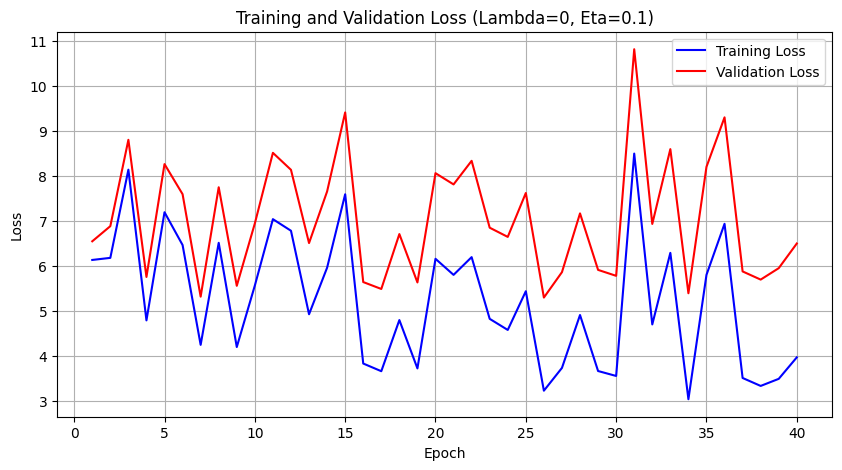

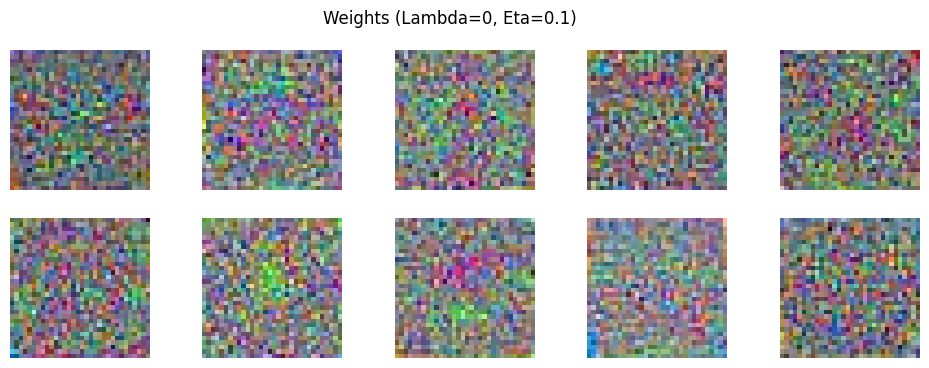


Experiment: Lambda=0, Eta=0.001
Current Date and Time (UTC): 2025-03-28 10:12:17
Student Name: Xinle Zhang
Current User's Login: woainio15200
Configuration: lambda=0, n-epochs=40, n-batch=100, eta=0.01
--------------------------------------------------
Epoch 1, Training Loss: 1.783
Epoch 2, Training Loss: 1.712
Epoch 3, Training Loss: 1.703
Epoch 4, Training Loss: 1.670
Epoch 5, Training Loss: 1.622
Epoch 6, Training Loss: 1.615
Epoch 7, Training Loss: 1.595
Epoch 8, Training Loss: 1.572
Epoch 9, Training Loss: 1.601
Epoch 10, Training Loss: 1.550
Epoch 11, Training Loss: 1.581
Epoch 12, Training Loss: 1.539
Epoch 13, Training Loss: 1.543
Epoch 14, Training Loss: 1.526
Epoch 15, Training Loss: 1.518
Epoch 16, Training Loss: 1.518
Epoch 17, Training Loss: 1.498
Epoch 18, Training Loss: 1.492
Epoch 19, Training Loss: 1.481
Epoch 20, Training Loss: 1.478
Epoch 21, Training Loss: 1.468
Epoch 22, Training Loss: 1.479
Epoch 23, Training Loss: 1.464
Epoch 24, Training Loss: 1.474
Epoch 25, T

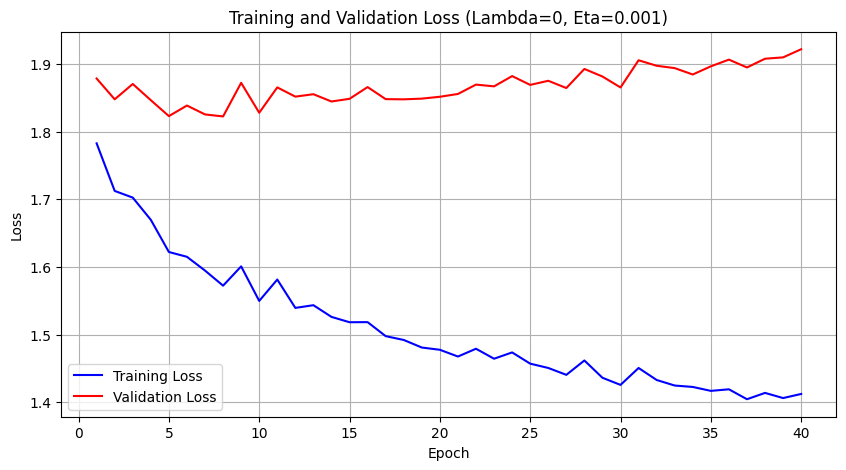

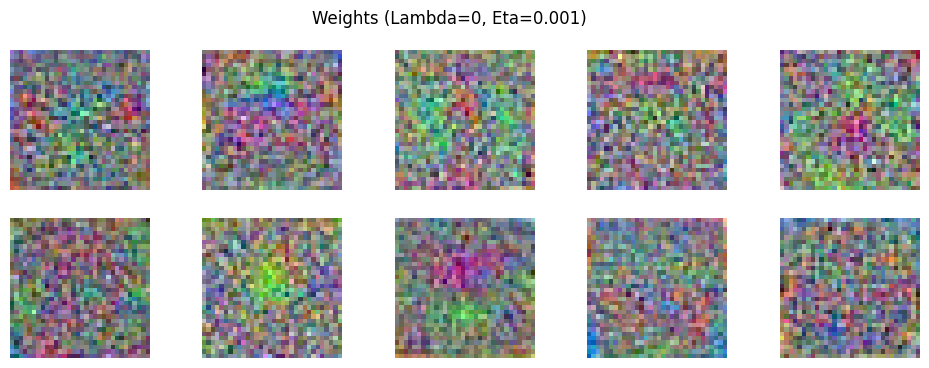


Experiment: Lambda=0.1, Eta=0.001
Current Date and Time (UTC): 2025-03-28 10:12:40
Student Name: Xinle Zhang
Current User's Login: woainio15200
Configuration: lambda=0.1, n-epochs=40, n-batch=100, eta=0.01
--------------------------------------------------
Epoch 1, Training Loss: 1.783
Epoch 2, Training Loss: 1.709
Epoch 3, Training Loss: 1.717
Epoch 4, Training Loss: 1.675
Epoch 5, Training Loss: 1.670
Epoch 6, Training Loss: 1.667
Epoch 7, Training Loss: 1.655
Epoch 8, Training Loss: 1.662
Epoch 9, Training Loss: 1.647
Epoch 10, Training Loss: 1.674
Epoch 11, Training Loss: 1.661
Epoch 12, Training Loss: 1.647
Epoch 13, Training Loss: 1.655
Epoch 14, Training Loss: 1.651
Epoch 15, Training Loss: 1.649
Epoch 16, Training Loss: 1.638
Epoch 17, Training Loss: 1.643
Epoch 18, Training Loss: 1.638
Epoch 19, Training Loss: 1.686
Epoch 20, Training Loss: 1.631
Epoch 21, Training Loss: 1.674
Epoch 22, Training Loss: 1.648
Epoch 23, Training Loss: 1.666
Epoch 24, Training Loss: 1.638
Epoch 2

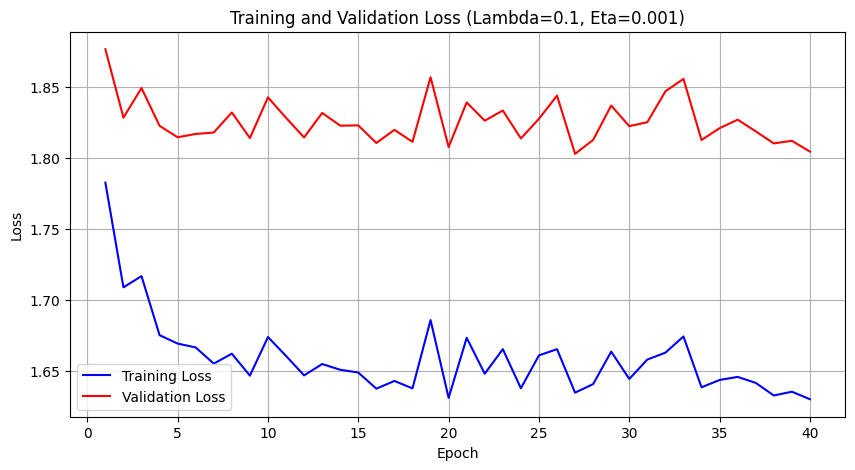

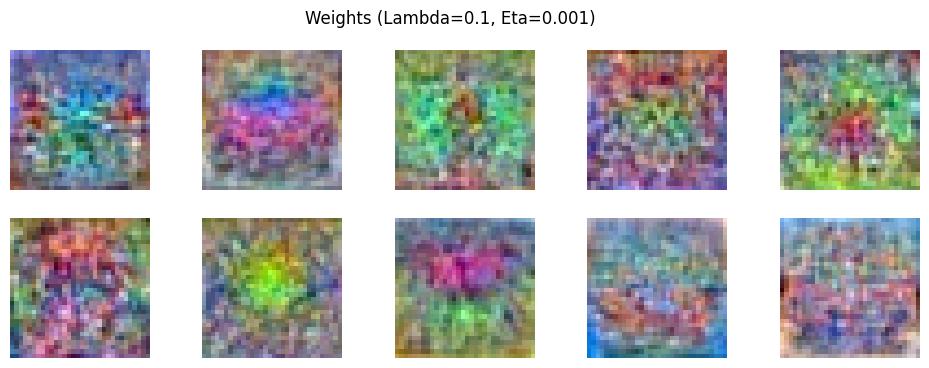


Experiment: Lambda=1, Eta=0.001
Current Date and Time (UTC): 2025-03-28 10:13:00
Student Name: Xinle Zhang
Current User's Login: woainio15200
Configuration: lambda=1, n-epochs=40, n-batch=100, eta=0.01
--------------------------------------------------
Epoch 1, Training Loss: 1.876
Epoch 2, Training Loss: 1.853
Epoch 3, Training Loss: 1.844
Epoch 4, Training Loss: 1.847
Epoch 5, Training Loss: 1.847
Epoch 6, Training Loss: 1.865
Epoch 7, Training Loss: 1.856
Epoch 8, Training Loss: 1.841
Epoch 9, Training Loss: 1.820
Epoch 10, Training Loss: 1.851
Epoch 11, Training Loss: 1.844
Epoch 12, Training Loss: 1.847
Epoch 13, Training Loss: 1.832
Epoch 14, Training Loss: 1.854
Epoch 15, Training Loss: 1.877
Epoch 16, Training Loss: 1.893
Epoch 17, Training Loss: 1.860
Epoch 18, Training Loss: 1.867
Epoch 19, Training Loss: 1.840
Epoch 20, Training Loss: 1.854
Epoch 21, Training Loss: 1.829
Epoch 22, Training Loss: 1.832
Epoch 23, Training Loss: 1.825
Epoch 24, Training Loss: 1.847
Epoch 25, T

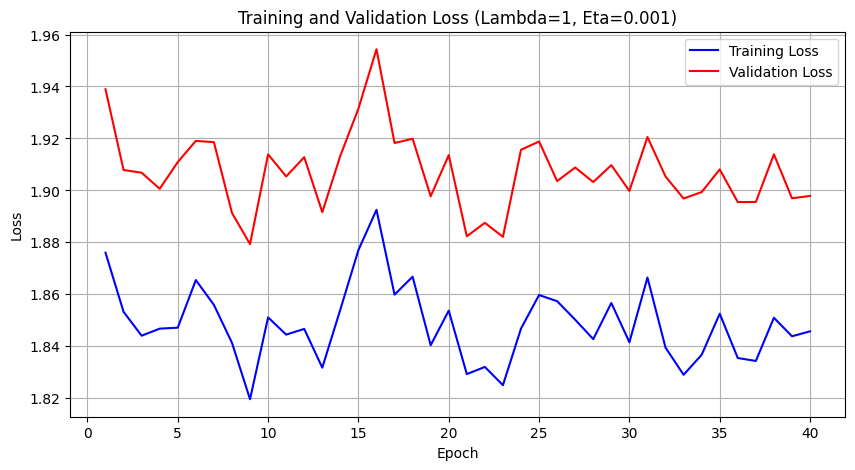

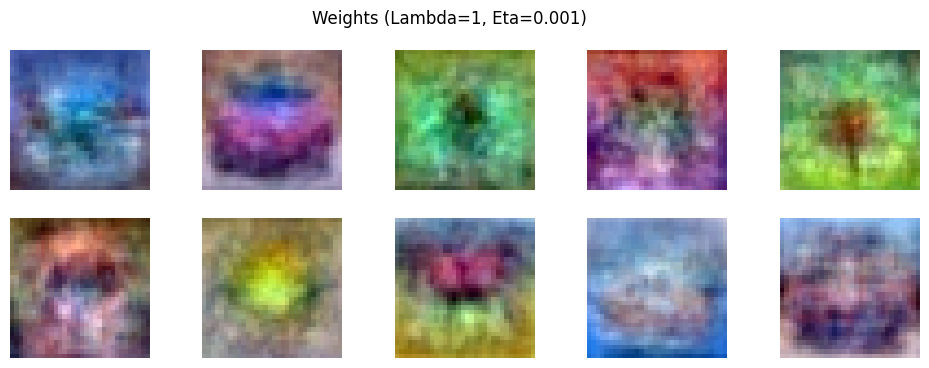


Experiment Summary:
Lambda=0, Eta=0.1: Test Accuracy = 28.52%
Lambda=0, Eta=0.001: Test Accuracy = 36.12%
Lambda=0.1, Eta=0.001: Test Accuracy = 37.72%
Lambda=1, Eta=0.001: Test Accuracy = 34.31%


In [26]:
# 当您想运行实验时，调用：
results = run_all_experiments()

Epoch 1, Training Loss: 5.721
Epoch 2, Training Loss: 6.497
Epoch 3, Training Loss: 4.911
Epoch 4, Training Loss: 4.950
Epoch 5, Training Loss: 4.579
Epoch 6, Training Loss: 6.711
Epoch 7, Training Loss: 3.426
Epoch 8, Training Loss: 8.360
Epoch 9, Training Loss: 5.222
Epoch 10, Training Loss: 6.698
Epoch 11, Training Loss: 5.087
Epoch 12, Training Loss: 6.970
Epoch 13, Training Loss: 8.021
Epoch 14, Training Loss: 4.874
Epoch 15, Training Loss: 4.373
Epoch 16, Training Loss: 4.202
Epoch 17, Training Loss: 8.351
Epoch 18, Training Loss: 4.231
Epoch 19, Training Loss: 3.643
Epoch 20, Training Loss: 5.052
Epoch 21, Training Loss: 7.936
Epoch 22, Training Loss: 6.302
Epoch 23, Training Loss: 7.804
Epoch 24, Training Loss: 4.049
Epoch 25, Training Loss: 5.246
Epoch 26, Training Loss: 3.720
Epoch 27, Training Loss: 3.971
Epoch 28, Training Loss: 6.906
Epoch 29, Training Loss: 4.407
Epoch 30, Training Loss: 5.553
Epoch 31, Training Loss: 5.105
Epoch 32, Training Loss: 6.782
Epoch 33, Trainin

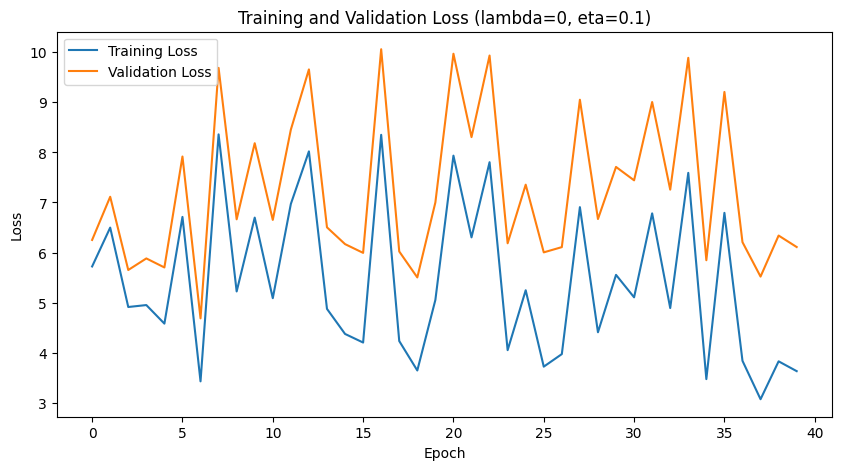

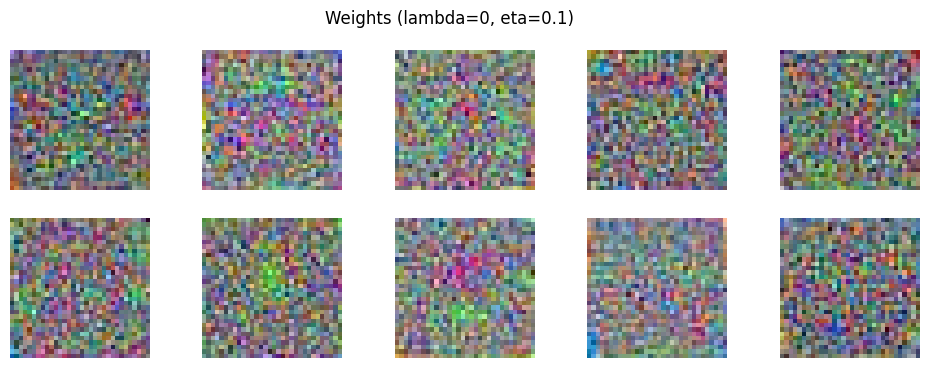

In [25]:
# 实验1: lambda=0, eta=0.1
GDparams = {
    'n_batch': 100,
    'eta': 0.1,
    'n_epochs': 40,
    'val_data': (valX, valY)
}

trained_net1, train_loss1, val_loss1 = MiniBatchGD(trainX, trainY, GDparams, init_net, lam=0, rng=rng)

# 计算测试集准确率
test_P = ApplyNetwork(testX, trained_net1)
test_acc = ComputeAccuracy(test_P, test_y)
print(f"Test accuracy (lambda=0, eta=0.1): {test_acc*100:.2f}%")

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_loss1, label='Training Loss')
plt.plot(val_loss1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (lambda=0, eta=0.1)')
plt.legend()
plt.show()
# 显示所有实验的权重可视化
visualize_weights(trained_net1, 'Weights (lambda=0, eta=0.1)')

Epoch 1, Training Loss: 1.973
Epoch 2, Training Loss: 1.893
Epoch 3, Training Loss: 1.850
Epoch 4, Training Loss: 1.820
Epoch 5, Training Loss: 1.800
Epoch 6, Training Loss: 1.781
Epoch 7, Training Loss: 1.767
Epoch 8, Training Loss: 1.753
Epoch 9, Training Loss: 1.743
Epoch 10, Training Loss: 1.734
Epoch 11, Training Loss: 1.727
Epoch 12, Training Loss: 1.717
Epoch 13, Training Loss: 1.710
Epoch 14, Training Loss: 1.704
Epoch 15, Training Loss: 1.699
Epoch 16, Training Loss: 1.692
Epoch 17, Training Loss: 1.687
Epoch 18, Training Loss: 1.683
Epoch 19, Training Loss: 1.677
Epoch 20, Training Loss: 1.673
Epoch 21, Training Loss: 1.668
Epoch 22, Training Loss: 1.665
Epoch 23, Training Loss: 1.660
Epoch 24, Training Loss: 1.657
Epoch 25, Training Loss: 1.653
Epoch 26, Training Loss: 1.649
Epoch 27, Training Loss: 1.646
Epoch 28, Training Loss: 1.644
Epoch 29, Training Loss: 1.640
Epoch 30, Training Loss: 1.638
Epoch 31, Training Loss: 1.634
Epoch 32, Training Loss: 1.631
Epoch 33, Trainin

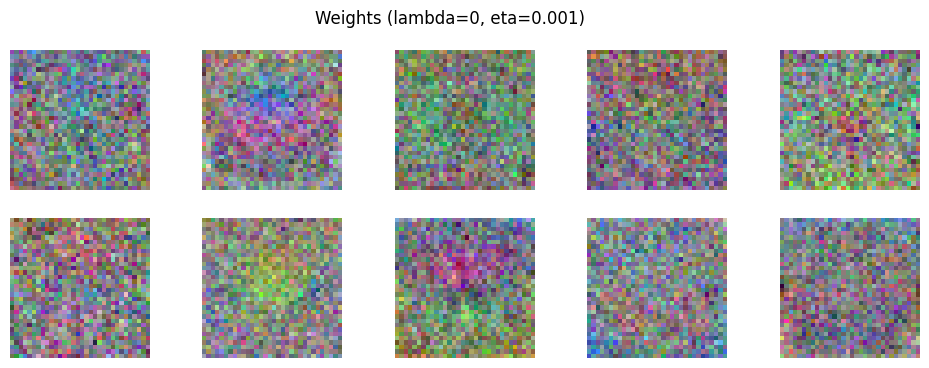

In [13]:
# 实验2: lambda=0, eta=0.001
GDparams['eta'] = 0.001
trained_net2, train_loss2, val_loss2 = MiniBatchGD(trainX, trainY, GDparams, init_net, lam=0, rng=rng)

test_P = ApplyNetwork(testX, trained_net2)
test_acc = ComputeAccuracy(test_P, test_y)
print(f"Test accuracy (lambda=0, eta=0.001): {test_acc*100:.2f}%")

visualize_weights(trained_net2, 'Weights (lambda=0, eta=0.001)')

Epoch 1, Training Loss: 1.972
Epoch 2, Training Loss: 1.893
Epoch 3, Training Loss: 1.850
Epoch 4, Training Loss: 1.820
Epoch 5, Training Loss: 1.801
Epoch 6, Training Loss: 1.784
Epoch 7, Training Loss: 1.772
Epoch 8, Training Loss: 1.759
Epoch 9, Training Loss: 1.749
Epoch 10, Training Loss: 1.739
Epoch 11, Training Loss: 1.731
Epoch 12, Training Loss: 1.724
Epoch 13, Training Loss: 1.718
Epoch 14, Training Loss: 1.713
Epoch 15, Training Loss: 1.709
Epoch 16, Training Loss: 1.702
Epoch 17, Training Loss: 1.698
Epoch 18, Training Loss: 1.695
Epoch 19, Training Loss: 1.690
Epoch 20, Training Loss: 1.688
Epoch 21, Training Loss: 1.685
Epoch 22, Training Loss: 1.680
Epoch 23, Training Loss: 1.678
Epoch 24, Training Loss: 1.675
Epoch 25, Training Loss: 1.672
Epoch 26, Training Loss: 1.670
Epoch 27, Training Loss: 1.667
Epoch 28, Training Loss: 1.665
Epoch 29, Training Loss: 1.663
Epoch 30, Training Loss: 1.661
Epoch 31, Training Loss: 1.659
Epoch 32, Training Loss: 1.657
Epoch 33, Trainin

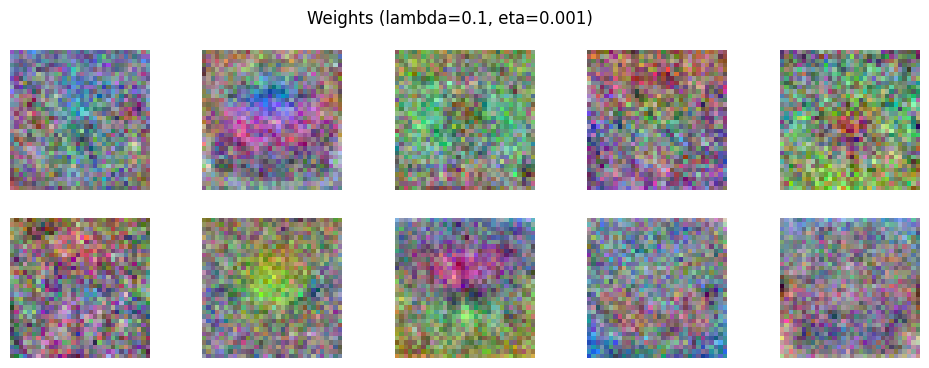

In [15]:
# 实验3: lambda=0.1, eta=0.001
trained_net3, train_loss3, val_loss3 = MiniBatchGD(trainX, trainY, GDparams, init_net, lam=0.1, rng=rng)

test_P = ApplyNetwork(testX, trained_net3)
test_acc = ComputeAccuracy(test_P, test_y)
print(f"Test accuracy (lambda=0.1, eta=0.001): {test_acc*100:.2f}%")
visualize_weights(trained_net3, 'Weights (lambda=0.1, eta=0.001)')

Epoch 1, Training Loss: 1.972
Epoch 2, Training Loss: 1.901
Epoch 3, Training Loss: 1.866
Epoch 4, Training Loss: 1.847
Epoch 5, Training Loss: 1.835
Epoch 6, Training Loss: 1.826
Epoch 7, Training Loss: 1.820
Epoch 8, Training Loss: 1.816
Epoch 9, Training Loss: 1.814
Epoch 10, Training Loss: 1.812
Epoch 11, Training Loss: 1.809
Epoch 12, Training Loss: 1.808
Epoch 13, Training Loss: 1.807
Epoch 14, Training Loss: 1.807
Epoch 15, Training Loss: 1.807
Epoch 16, Training Loss: 1.806
Epoch 17, Training Loss: 1.806
Epoch 18, Training Loss: 1.805
Epoch 19, Training Loss: 1.805
Epoch 20, Training Loss: 1.805
Epoch 21, Training Loss: 1.804
Epoch 22, Training Loss: 1.804
Epoch 23, Training Loss: 1.804
Epoch 24, Training Loss: 1.805
Epoch 25, Training Loss: 1.805
Epoch 26, Training Loss: 1.804
Epoch 27, Training Loss: 1.804
Epoch 28, Training Loss: 1.804
Epoch 29, Training Loss: 1.804
Epoch 30, Training Loss: 1.803
Epoch 31, Training Loss: 1.804
Epoch 32, Training Loss: 1.804
Epoch 33, Trainin

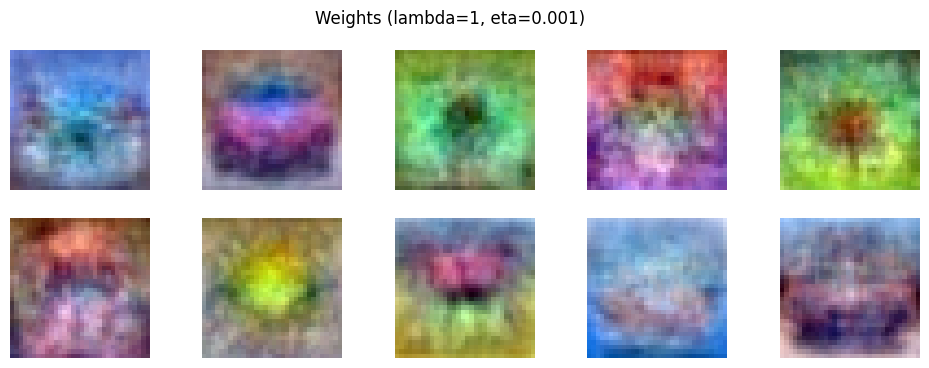

In [16]:
# 实验4: lambda=1, eta=0.001
trained_net4, train_loss4, val_loss4 = MiniBatchGD(trainX, trainY, GDparams, init_net, lam=1, rng=rng)

test_P = ApplyNetwork(testX, trained_net4)
test_acc = ComputeAccuracy(test_P, test_y)
print(f"Test accuracy (lambda=1, eta=0.001): {test_acc*100:.2f}%")
visualize_weights(trained_net4, 'Weights (lambda=1, eta=0.001)')

In [27]:
# === Bonus Part 1: Performance Optimization ===
# Cell 1: Load all training data
def LoadAllData():
    """加载所有训练数据"""
    X_all = []
    Y_all = []
    y_all = []

    for i in range(1, 6):
        filename = f'cifar-10-batches-py/data_batch_{i}'
        X, Y, y = LoadBatch(filename)
        X_all.append(X)
        Y_all.append(Y)
        y_all.append(y)

    return np.concatenate(X_all, axis=1), np.concatenate(Y_all, axis=1), np.concatenate(y_all)

In [40]:
def augment_batch(X, rng):
    # 水平翻转
    flip_mask = rng.random(X.shape[1]) < 0.5
    if np.any(flip_mask):
        X[:, flip_mask] = HorizontalFlip(X[:, flip_mask])

    # 添加随机噪声
    noise = rng.normal(0, 0.01, X.shape)
    X = X + noise

    # 随机亮度调整
    brightness = rng.uniform(0.8, 1.2, (1, X.shape[1]))
    X = X * brightness

    return X

In [28]:
# Cell 2: Create validation set and data augmentation
def CreateValidationSet(X, Y, y, val_size=1000):
    """从训练数据中分离验证集"""
    n = X.shape[1]
    indices = np.random.permutation(n)
    return (X[:, indices[val_size:]], Y[:, indices[val_size:]], y[indices[val_size:]],
            X[:, indices[:val_size]], Y[:, indices[:val_size]], y[indices[:val_size]])

def HorizontalFlip(X):
    """水平翻转图像"""
    aa = np.int32(np.arange(32)).reshape((32, 1))
    bb = np.int32(np.arange(31, -1, -1)).reshape((32, 1))
    vv = np.tile(32*aa, (1, 32))
    ind_flip = vv.reshape((32*32, 1)) + np.tile(bb, (32, 1))
    inds_flip = np.vstack((ind_flip, 1024+ind_flip, 2048+ind_flip)).flatten()
    return X[inds_flip]

In [41]:
def MiniBatchGD_Improved(X, Y, GDparams, init_net, lam, rng=None):
    """改进版小批量梯度下降训练"""
    trained_net = copy.deepcopy(init_net)
    n = X.shape[1]

    # 初始化动量
    momentum = 0.9
    v_W = np.zeros_like(init_net['W'])
    v_b = np.zeros_like(init_net['b'])

    # 早停相关
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    best_net = None

    train_loss = []
    val_loss = []
    eta = GDparams['eta']

    for epoch in range(GDparams['n_epochs']):
        # 学习率衰减
        eta = GDparams['eta'] * (0.95 ** epoch)

        if rng is not None:
            perm = rng.permutation(n)
            X = X[:, perm]
            Y = Y[:, perm]

        for j in range(n // GDparams['n_batch']):
            j_start = j * GDparams['n_batch']
            j_end = (j+1) * GDparams['n_batch']

            Xbatch = X[:, j_start:j_end]
            Ybatch = Y[:, j_start:j_end]

            # 增强的数据增强
            Xbatch = augment_batch(Xbatch, rng)

            P = ApplyNetwork(Xbatch, trained_net)
            grads = BackwardPass(Xbatch, Ybatch, P, trained_net, lam)

            # 使用动量更新
            v_W = momentum * v_W - eta * grads['W']
            v_b = momentum * v_b - eta * grads['b']
            trained_net['W'] += v_W
            trained_net['b'] += v_b

        # 计算损失
        P = ApplyNetwork(X, trained_net)
        loss = ComputeLoss(P, Y)
        train_loss.append(loss)

        # 验证和早停
        if 'val_data' in GDparams:
            P_val = ApplyNetwork(GDparams['val_data'][0], trained_net)
            val_loss_current = ComputeLoss(P_val, GDparams['val_data'][1])
            val_loss.append(val_loss_current)

            if val_loss_current < best_val_loss:
                best_val_loss = val_loss_current
                best_net = copy.deepcopy(trained_net)
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                return best_net, train_loss, val_loss

        print(f"Epoch {epoch+1}, Loss: {loss:.3f}, Learning Rate: {eta:.6f}")

    return best_net if best_net is not None else trained_net, train_loss, val_loss

In [30]:
# Cell 4: Grid Search
def GridSearch(trainX, trainY, valX, valY, init_net, rng):
    """参数网格搜索"""
    learning_rates = [0.1, 0.01, ]
    batch_sizes = [50, 100, ]
    lambda_values = [0, 0.01, 0.1]

    best_acc = 0
    best_params = None

    for eta in learning_rates:
        for n_batch in batch_sizes:
            for lam in lambda_values:
                print(f"\nTrying eta={eta}, n_batch={n_batch}, lambda={lam}")

                GDparams = {
                    'n_batch': n_batch,
                    'eta': eta,
                    'n_epochs': 20,
                    'val_data': (valX, valY)
                }

                trained_net, _, _ = MiniBatchGD_Improved(trainX, trainY,
                                                       GDparams, init_net, lam, rng)

                val_P = ApplyNetwork(valX, trained_net)
                val_acc = ComputeAccuracy(val_P, val_y)

                if val_acc > best_acc:
                    best_acc = val_acc
                    best_params = {'eta': eta, 'n_batch': n_batch, 'lambda': lam}

    return best_params

In [31]:
# === Bonus Part 2: Multiple Binary Cross-Entropy Loss ===
# Cell 5: BCE Network and Loss Functions
def ApplyNetwork_BCE(X, network, temperature=1.0):
    s = network['W'] @ X + network['b']
    P = 1 / (1 + np.exp(-s/temperature))
    return P

def ComputeLoss_BCE(P, Y):
    """计算多个二元交叉熵损失"""
    n = P.shape[1]
    eps = 1e-15
    P = np.clip(P, eps, 1-eps)
    L = -np.sum(Y * np.log(P) + (1-Y) * np.log(1-P)) / (n * P.shape[0])
    return L

def BackwardPass_BCE(X, Y, P, network, lam):
    """多个二元交叉熵损失的反向传播"""
    n = X.shape[1]
    K = P.shape[0]
    g = (P - Y) / K

    dW = (g @ X.T) / n + 2 * lam * network['W']
    db = np.sum(g, axis=1, keepdims=True) / n

    return {'W': dW, 'b': db}

In [32]:
# Cell 6: BCE Training
def MiniBatchGD_BCE(X, Y, GDparams, init_net, lam, rng=None, momentum=0.9):
    """使用BCE损失的训练，添加momentum"""
    trained_net = copy.deepcopy(init_net)
    n = X.shape[1]

    # 初始化momentum的速度项
    v_W = np.zeros_like(init_net['W'])
    v_b = np.zeros_like(init_net['b'])

    train_loss = []
    val_loss = []

    for epoch in range(GDparams['n_epochs']):
        if rng is not None:
            perm = rng.permutation(n)
            X = X[:, perm]
            Y = Y[:, perm]

        for j in range(n // GDparams['n_batch']):
            j_start = j * GDparams['n_batch']
            j_end = (j+1) * GDparams['n_batch']

            Xbatch = X[:, j_start:j_end]
            Ybatch = Y[:, j_start:j_end]

            P = ApplyNetwork_BCE(Xbatch, trained_net)
            grads = BackwardPass_BCE(Xbatch, Ybatch, P, trained_net, lam)

            # 使用momentum更新参数
            v_W = momentum * v_W - GDparams['eta'] * grads['W']
            v_b = momentum * v_b - GDparams['eta'] * grads['b']
            trained_net['W'] += v_W
            trained_net['b'] += v_b

        P = ApplyNetwork_BCE(X, trained_net)
        loss = ComputeLoss_BCE(P, Y)
        train_loss.append(loss)

        if 'val_data' in GDparams:
            P_val = ApplyNetwork_BCE(GDparams['val_data'][0], trained_net)
            val_loss.append(ComputeLoss_BCE(P_val, GDparams['val_data'][1]))

        print(f"Epoch {epoch+1}, BCE Loss: {loss:.3f}")

    return trained_net, train_loss, val_loss

In [33]:
# Cell 7: Probability Distribution Analysis
def plot_probability_histograms(P_test, test_y, title):
    """绘制正确和错误分类样本的概率直方图"""
    pred = np.argmax(P_test, axis=0)
    correct_mask = pred == test_y

    true_probs_correct = [P_test[test_y[i], i] for i in range(len(test_y)) if correct_mask[i]]
    true_probs_incorrect = [P_test[test_y[i], i] for i in range(len(test_y)) if not correct_mask[i]]

    plt.figure(figsize=(10, 5))
    plt.hist(true_probs_correct, bins=50, alpha=0.5, label='Correct predictions')
    plt.hist(true_probs_incorrect, bins=50, alpha=0.5, label='Incorrect predictions')
    plt.xlabel('Probability of true class')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.show()

In [36]:
def ComputeGradsWithTorch(X, y, network_params):

    # torch requires arrays to be torch tensors
    Xt = torch.from_numpy(X)

    # will be computing the gradient w.r.t. these parameters
    W = torch.tensor(network_params['W'], requires_grad=True)
    b = torch.tensor(network_params['b'], requires_grad=True)

    N = X.shape[1]

    scores = torch.matmul(W, Xt)  + b;

    ## give an informative name to this torch class
    apply_softmax = torch.nn.Softmax(dim=0)

    # apply softmax to each column of scores
    P = apply_softmax(scores)

    ## compute the loss
    loss = torch.mean(-torch.log(P[y, np.arange(N)]))

    # compute the backward pass relative to the loss and the named parameters
    loss.backward()

    # extract the computed gradients and make them numpy arrays
    grads = {}
    grads['W'] = W.grad.numpy()
    grads['b'] = b.grad.numpy()

    return grads

In [1]:
# Cell 8: Run Bonus Experiments
# 1. 加载所有数据
print("Loading all training data...")
X_all, Y_all, y_all = LoadAllData()
trainX, trainY, train_y, valX, valY, val_y = CreateValidationSet(X_all, Y_all, y_all)

# 2. 执行网格搜索
print("\nPerforming grid search...")
best_params = GridSearch(trainX, trainY, valX, valY, init_net, rng)
print("Best parameters:", best_params)

# 3. 使用最佳参数进行训练
GDparams_imp = {
    'n_batch': best_params['n_batch'],
    'eta': best_params['eta'],
    'n_epochs': 20,
    'val_data': (valX, valY)
}

trained_net_imp, train_loss_imp, val_loss_imp = MiniBatchGD_Improved(
    trainX, trainY, GDparams_imp, init_net, best_params['lambda'], rng)

# BCE训练
print("\nTraining with BCE loss...")
GDparams_bce = GDparams_imp.copy()
GDparams_bce['eta'] *= 10  # 增大学习率补偿1/K因子

trained_net_bce, train_loss_bce, val_loss_bce = MiniBatchGD_BCE(
    trainX, trainY, GDparams_bce, init_net, best_params['lambda'],
    rng=rng,  # 明确指定rng参数
    momentum=0.9  # 明确指定momentum参数
)
# 评估结果
test_P_imp = ApplyNetwork(testX, trained_net_imp)
test_acc_imp = ComputeAccuracy(test_P_imp, test_y)
print(f"\nImproved model test accuracy: {test_acc_imp*100:.2f}%")

test_P_bce = ApplyNetwork_BCE(testX, trained_net_bce)
test_acc_bce = ComputeAccuracy(test_P_bce, test_y)
print(f"BCE model test accuracy: {test_acc_bce*100:.2f}%")

# 分析概率分布
plot_probability_histograms(test_P_imp, test_y, 'Softmax + Cross-entropy')
plot_probability_histograms(test_P_bce, test_y, 'Multiple Binary Cross-entropy')

Loading all training data...


NameError: name 'LoadAllData' is not defined


Validating gradient computations...

W gradient check:
Max relative error: 2.10e-16
✓ Gradients match!

b gradient check:
Max relative error: 1.38e-16
✓ Gradients match!


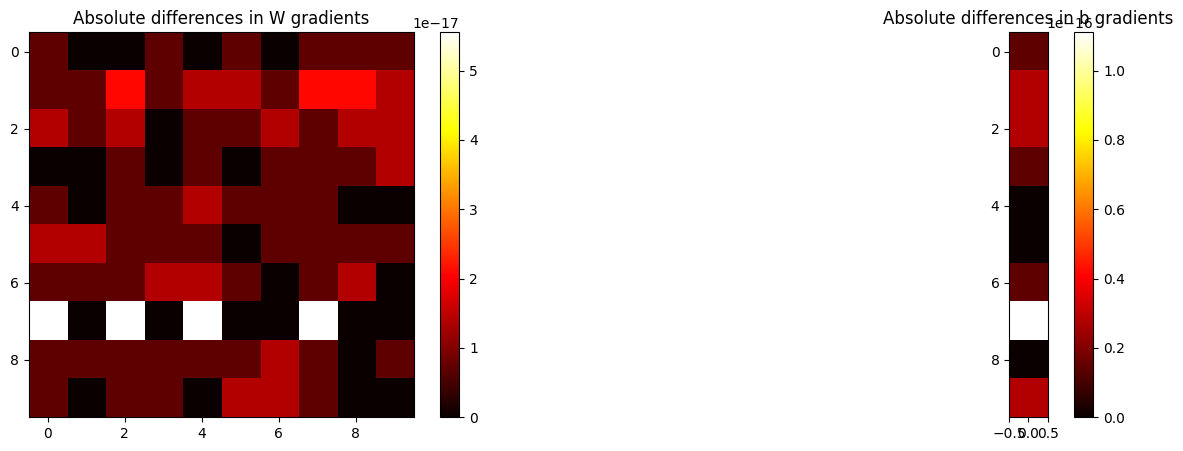

In [38]:
# 梯度验证
print("\nValidating gradient computations...")

# 创建小规模测试数据
d_small = 10  # 减少输入维度
n_small = 3   # 减少样本数量
K = 10        # 类别数保持不变

# 设置随机种子以确保结果可重现
rng = np.random.default_rng(42)

# 初始化小规模网络参数
small_net = {
    'W': 0.01 * rng.standard_normal(size=(K, d_small)),
    'b': np.zeros((K, 1))
}

# 创建小规模测试数据
X_small = trainX[0:d_small, 0:n_small]
Y_small = trainY[:, 0:n_small]
y_small = train_y[0:n_small]

# 执行前向传播
P_small = ApplyNetwork(X_small, small_net)

# 计算我们实现的梯度
my_grads = BackwardPass(X_small, Y_small, P_small, small_net, lam=0)

# 计算PyTorch的梯度
torch_grads = ComputeGradsWithTorch(X_small, y_small, small_net)

# 比较梯度
def compare_gradients(grad1, grad2, name, tolerance=1e-6):
    """比较梯度并计算相对误差"""
    abs_diff = np.abs(grad1 - grad2)
    rel_error = abs_diff / np.maximum(1e-8, np.abs(grad1) + np.abs(grad2))
    max_rel_error = np.max(rel_error)
    print(f"\n{name} gradient check:")
    print(f"Max relative error: {max_rel_error:.2e}")
    if max_rel_error < tolerance:
        print("✓ Gradients match!")
    else:
        print("✗ Gradients differ!")
        print("Sample of differences:")
        # 打印一些较大误差的位置
        large_diff_idx = np.where(rel_error > tolerance)
        for i, j in zip(*large_diff_idx)[:5]:  # 只显示前5个
            print(f"Position [{i},{j}]:")
            print(f"Our gradient: {grad1[i,j]:.6f}")
            print(f"Torch gradient: {grad2[i,j]:.6f}")

# 比较W和b的梯度
compare_gradients(my_grads['W'], torch_grads['W'], "W")
compare_gradients(my_grads['b'], torch_grads['b'], "b")

# 可视化梯度差异
plt.figure(figsize=(15, 5))

# W的梯度差异可视化
plt.subplot(121)
plt.imshow(np.abs(my_grads['W'] - torch_grads['W']), cmap='hot')
plt.colorbar()
plt.title('Absolute differences in W gradients')

# b的梯度差异可视化
plt.subplot(122)
plt.imshow(np.abs(my_grads['b'] - torch_grads['b']), cmap='hot')
plt.colorbar()
plt.title('Absolute differences in b gradients')
plt.show()